In [1]:
import pandas as pd
import numpy as np
import random
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

In [3]:
from collections import defaultdict, Counter

In [4]:
import os
import sys

In [5]:
sys.path.append( os.path.join('.','original', 'code') )

In [6]:
from original.code import nsfg, analytic

In [7]:
df_orig = nsfg.ReadFemPreg('original/code/2002FemPreg.dct', 'original/code/2002FemPreg.dat.gz')
df_orig.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [8]:
used_cols = ['caseid', 'prglngth', 'outcome', 'pregordr', 'birthord', 'birthwgt_lb', 'birthwgt_oz', 'agepreg', 'finalwgt']
df = df_orig.loc[:,used_cols]
df.head()

,caseid,prglngth,outcome,pregordr,birthord,birthwgt_lb,birthwgt_oz,agepreg,finalwgt
0,1,39,1,1,1.0,8.0,13.0,33.16,6448.271112
1,1,39,1,2,2.0,7.0,14.0,39.25,6448.271112
2,2,39,1,1,1.0,9.0,2.0,14.33,12999.542264
3,2,39,1,2,2.0,7.0,0.0,17.83,12999.542264
4,2,39,1,3,3.0,6.0,3.0,18.33,12999.542264


In [9]:
# Clean up
na_vals = [97, 98, 99]

#df[(df.birthwgt_oz.isin(na_vals)) | (df.birthwgt_lb.isin(na_vals))]
df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)

df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz/16.0
df.sample()

,caseid,prglngth,outcome,pregordr,birthord,birthwgt_lb,birthwgt_oz,agepreg,finalwgt,totalwgt_lb
10056,9296,41,1,1,1.0,7.0,13.0,18.66,3126.749541,7.8125


In [10]:
# Validate against published summary
df.outcome.value_counts().sort_index()

1    9148
2    1862
3     120
4    1921
5     190
6     352
Name: outcome, dtype: int64

In [11]:
df.birthwgt_lb.value_counts(sort=False).sort_index()

0.0        8
1.0       40
2.0       53
3.0       98
4.0      229
5.0      697
6.0     2223
7.0     3049
8.0     1889
9.0      623
10.0     132
11.0      26
12.0      10
13.0       3
14.0       3
15.0       1
Name: birthwgt_lb, dtype: int64

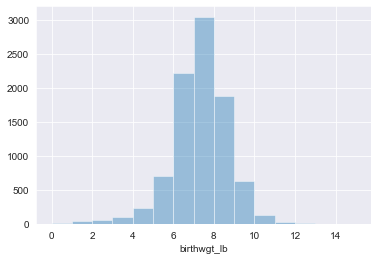

In [12]:
sns.distplot(df.birthwgt_lb.dropna(), bins=15, kde=False);

In [13]:
pregmap = defaultdict( list )
for index, caseid in df.caseid.items():
    pregmap[caseid].append(index)

In [14]:
len(pregmap)

5033

In [15]:
caseid = 10229
indices = pregmap[caseid]
df.loc[indices, 'outcome']

11093    4
11094    4
11095    4
11096    4
11097    4
11098    4
11099    1
Name: outcome, dtype: int64

In [16]:
df[df.caseid==10229].outcome

11093    4
11094    4
11095    4
11096    4
11097    4
11098    4
11099    1
Name: outcome, dtype: int64

## Distributions

In [17]:
live = df.loc[df.outcome == 1].copy()
live.shape

(9148, 10)

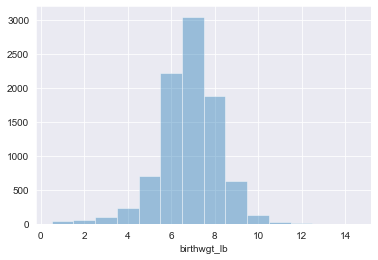

In [18]:
sns.distplot(live.birthwgt_lb.dropna(), kde=False, bins=np.arange(0.5,15.5,1));

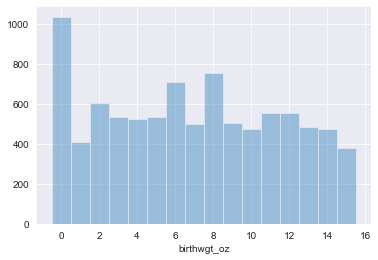

In [19]:
sns.distplot(live.birthwgt_oz.dropna(), bins=np.arange(-0.5,16.5, 1), kde=False);

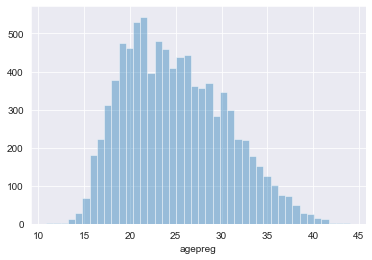

In [20]:
sns.distplot(live.agepreg, kde=False);

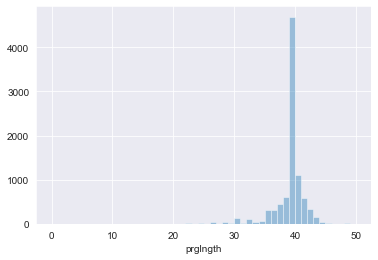

In [21]:
sns.distplot(live.prglngth, kde=False);

In [22]:
# Outliers
live.prglngth.sort_values().unique()[:10]

# look like errors, births at less than 22 weeks of pregnancy

array([ 0,  4,  9, 13, 17, 18, 19, 20, 21, 22])

In [23]:
live.prglngth.value_counts().sort_index()[-7:]

43    148
44     46
45     10
46      1
47      1
48      7
50      2
Name: prglngth, dtype: int64

In [24]:
live['firstborn'] = live['birthord']==1
live.head()

,caseid,prglngth,outcome,pregordr,birthord,birthwgt_lb,birthwgt_oz,agepreg,finalwgt,totalwgt_lb,firstborn
0,1,39,1,1,1.0,8.0,13.0,33.16,6448.271112,8.8125,True
1,1,39,1,2,2.0,7.0,14.0,39.25,6448.271112,7.8750,False
2,2,39,1,1,1.0,9.0,2.0,14.33,12999.542264,9.1250,True
3,2,39,1,2,2.0,7.0,0.0,17.83,12999.542264,7.0000,False
4,2,39,1,3,3.0,6.0,3.0,18.33,12999.542264,6.1875,False


In [25]:
firsts = live[live.birthord==1]
others = live[live.birthord!=1]

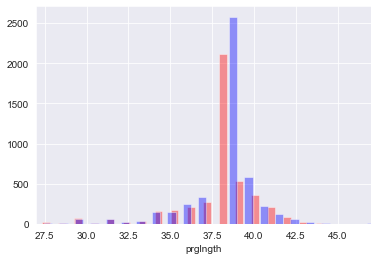

In [26]:
plt.xlim(27, 47);
ax = sns.distplot( firsts.prglngth, kde=False, color='r', 
                  hist_kws={'align': 'left', 'width': 0.45});
sns.distplot( others.prglngth, kde=False, color='b', 
             hist_kws={'align': 'left', 'width': 0.5}, ax=ax);

In [27]:
'{:.2f}, {:.2f}, {:.2f}'.format(live.prglngth.mean(), live.prglngth.var(),live.prglngth.std())

'38.56, 7.30, 2.70'

In [28]:
'{:.3f} {:.3f}'.format(firsts.prglngth.mean(), others.prglngth.mean())

'38.601 38.523'

In [29]:
def CohenEffectSize(group1, group2):
    diff_mean = group1.mean() - group2.mean()
    
    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)
    
    pooled_var = (n1*var1 + n2*var2)/(n1 + n2)
    d = diff_mean/np.sqrt(pooled_var)
    
    return d

In [30]:
round( CohenEffectSize(firsts.prglngth, others.prglngth), 3 )

0.029

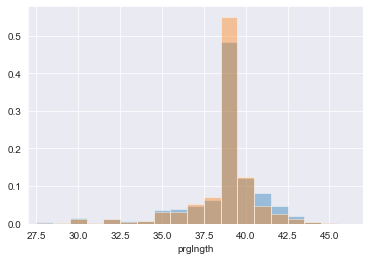

In [31]:
bins = np.arange(27.5, 47.5)
ax = sns.distplot(firsts.prglngth, norm_hist=True, kde=False, bins=bins);
sns.distplot(others.prglngth, norm_hist=True, kde=False, bins=bins,  ax=ax);
ax.set_xlim(27, 47);

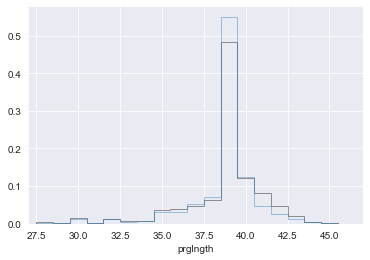

In [32]:
bins = np.arange(27.5, 47.5)
ax = sns.distplot(firsts.prglngth, norm_hist=True, kde=False, bins=bins, hist_kws={'histtype': 'step'}, color='k');
sns.distplot(others.prglngth, norm_hist=True, kde=False, bins=bins, hist_kws={'histtype': 'step'}, label='others', ax=ax);
ax.set_xlim(27, 47);

In [33]:
first_pmf = firsts.prglngth.value_counts(normalize=True).sort_index()
other_pmf = others.prglngth.value_counts(normalize=True).sort_index()

In [34]:
weeks = list(range(35, 46))
diffs = []
for week in weeks:
    diffs.append( 100 * (first_pmf[week] - other_pmf[week]))

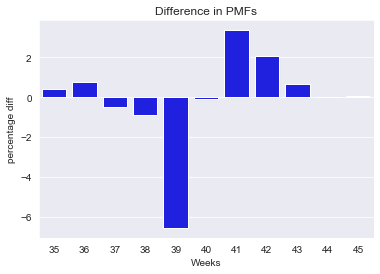

In [35]:
ax = sns.barplot(weeks, diffs, color='b');
ax.set(xlabel='Weeks', ylabel='percentage diff', title='Difference in PMFs');

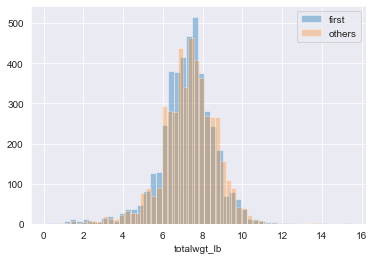

In [36]:
ax = sns.distplot(firsts.totalwgt_lb.dropna(), kde=False, label='first');
sns.distplot(others.totalwgt_lb.dropna(), kde=False, label='others', ax=ax, hist_kws={'alpha': 0.3});
plt.legend();

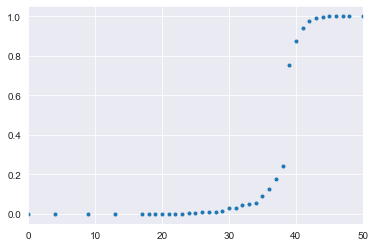

In [37]:
prglngth_cdf = live.prglngth.value_counts(normalize=True).sort_index().cumsum()
prglngth_cdf.plot(style='.');

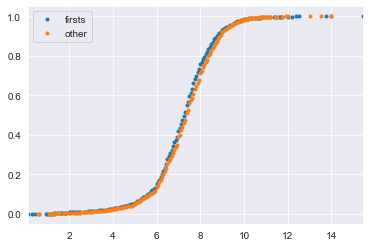

In [38]:
ax = firsts.totalwgt_lb.value_counts(normalize=True).sort_index().cumsum().plot(style='.', label='firsts');
others.totalwgt_lb.value_counts(normalize=True).sort_index().cumsum().plot(style='.', label='other', ax=ax);
plt.legend();

In [39]:
weights = live.totalwgt_lb
weights_cdf = weights.value_counts(normalize=True).sort_index().cumsum()
samples = np.random.choice(weights.dropna(), 100, replace=True)

In [40]:
ranks = np.array([weights_cdf[sample] for sample in samples])
ranks_cdf = [len(ranks[ranks<=x])/len(ranks) for x in ranks]

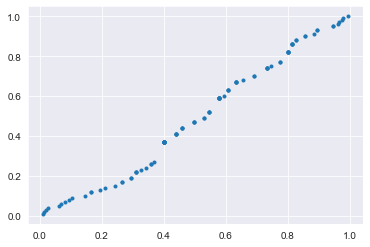

In [41]:
plt.plot(ranks, ranks_cdf, '.');

In [42]:
test = np.random.random(1000)
test_cdf = [len(test[test<=x])/len(test) for x in test]
test_pmf = [len(test==x)/len(test) for x in test]

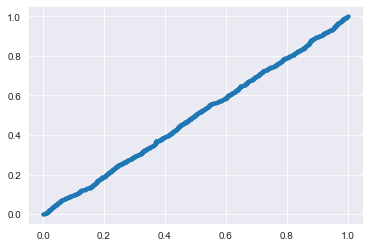

In [43]:
plt.plot(test, test_cdf, '.');

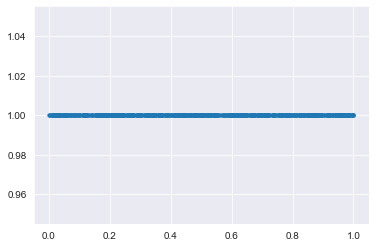

In [44]:
plt.plot(test, test_pmf, '.');

In [45]:
bb = analytic.ReadBabyBoom('original/code/babyboom.dat')
diffs = bb.minutes.diff()
cdf = diffs.value_counts(normalize=True).sort_index().cumsum()

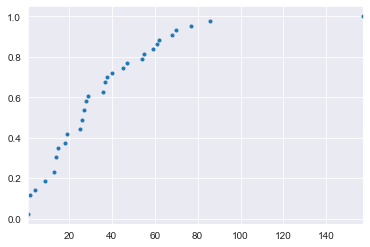

In [46]:
cdf.plot(style='.');

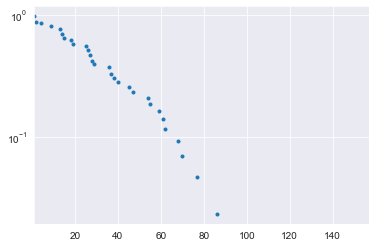

In [47]:
(1-cdf).plot(logy=True, style='.');

In [48]:
stats.norm.cdf(0)

0.5